In [1]:
# Drive mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# GPU Check
!nvidia-smi

Sat Feb  1 14:09:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

torch.Size([4, 128, 128, 3]) torch.Size([4])


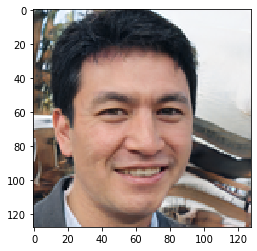

tensor(1)


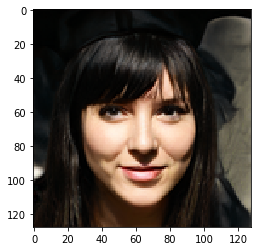

tensor(4)


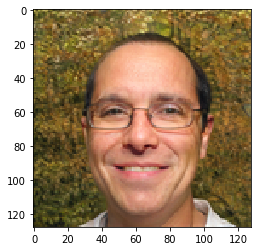

tensor(2)


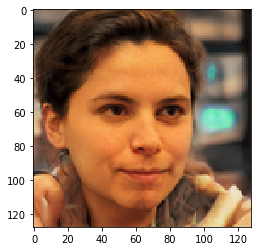

tensor(4)


In [24]:
#####################################
# Data Set                          #
#####################################
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage import transform

import imgaug as ia
from imgaug import augmenters as iaa

class FaceDataset(Dataset):
    def __init__(self, train_table, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_table = train_table
        
        self.H = 128 # Height
        self.W = 128 # Width
        self.transform = transform
        
    def __len__(self):
        return len(self.train_table)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # to list
        
        filename = self.train_table['filename'][idx]
        img_file = self.train_dir + filename
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.train_table['label'][idx]

        sample = {'img' : img, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

#####################################
# Data Loader                       #
#####################################

from torch.utils.data import DataLoader

root = 'drive/My Drive/team10'
train_dir = root + '/face_images_128x128/'
train_csv = glob.glob(root + '/csvs/*train*')[0]

# Split train and validation data
train_table = pd.read_csv(train_csv)
valid_table = train_table.sample(frac=0.2, random_state=999)
train_table.drop(index=valid_table.index, axis=0, inplace=True)

# Reset index (0, 1, 2, ...)
train_table.reset_index(inplace=True)
valid_table.reset_index(inplace=True)

BATCH_SIZE = 4

train_dataset = FaceDataset(train_table=train_table, train_dir=train_dir)
valid_dataset = FaceDataset(train_table=valid_table, train_dir=train_dir)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

for i in valid_loader:
  print(np.shape(i['img']), np.shape(i['label']))

  for j in range(BATCH_SIZE):
    img = i['img'][j]
    label = i['label'][j]

    plt.imshow(img)
    plt.show()
    print(label)
  break

In [0]:
#####################################
# Model, Loss, Optimizer            #
#####################################

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

N_CLASS = 6
LEARNING_RATE = 1e-4

model = models.resnet18()
model.fc = nn.Linear(in_features=512, out_features=N_CLASS, bias=True)

crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [0]:
#####################################
# Train                             #
#####################################

from tqdm import tqdm

N_EPOCH = 100
min_loss = float('inf')

for ith, epoch in enumerate(range(N_EPOCH), start=1):
  loss_per_epoch = 0.0
  
  for batch in tqdm(train_loader):
    img = batch['img'].to(device, dtype=torch.float)
    label = batch['label'].to(device, dtype=torch.float)
    
    print(np.shape(img))
    print(label)
    # optimizer.zero_grad()
    # out = model(img)

    # loss = crossEntropyLoss(out, label)
    # loss.backward()
    # optimizer.step()
    # loss_per_epoch += loss
    
    # if loss < min_loss:
    #     torch.save(model, weight_savename)
    #     min_loss = loss
    break
  break
          
  loss_per_epoch /= len(train_loader)
  print('epoch: {}, train loss: {}'.format(epoch + 1, loss_per_epoch))
  
  # # Log on the tensorboard
  # writer.add_scalar('training loss',
  #                     loss_per_epoch,
  #                     epoch * ith)

  0%|          | 0/14 [00:00<?, ?it/s]

KeyError: ignored